# Box Office Revenue Predictictive Models

### Data Wrangling Notebook


The purpose of this project is to further practice building my own models in order to build and evaluate the performance of models that predict the revenue of movies, as a function of features associated with them.

These models will be evaluated against relevant KPI's (R-squared, Mean Absolute Error, MAE^2), and the best model will be used to predict revenue performance for movies in a world where theaters continued to stay open in 2020 and 2021.  

This notebook's purpose is to prepare the data set(s) for exploratory analysis in a subsequent notebook. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import ast

**Load Box office data**

Here I load in both .csv files with the box-office data.  The data was pre-split for a Kaggle competition years ago. In this instance I chose to merge both files into a single dataframe and later will use SciKit Learn to create a new train/test split for modeling. 

Data Source: 

Kaggle. (May 2019). TMDB Box Office Prediction, V1. Retrieved 04/16/2021 from https://www.kaggle.com/c/tmdb-box-office-prediction/data.

In [2]:
boxoffice = pd.read_csv(r'C:\Users\deann\Documents\Data\Box Office Prediction Data\train.csv')

pd.set_option("display.max_colwidth", 20)

boxoffice.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, ...",14000000,"[{'id': 35, 'nam...",NaN,tt2637294,en,Hot Tub Time Mac...,"When Lou, who ha...",6.575393,...,2/20/15,93.0,[{'iso_639_1': '...,Released,The Laws of Spac...,Hot Tub Time Mac...,"[{'id': 4379, 'n...","[{'cast_id': 4, ...",[{'credit_id': '...,12314651
1,2,"[{'id': 107674, ...",40000000,"[{'id': 35, 'nam...",NaN,tt0368933,en,The Princess Dia...,Mia Thermopolis ...,8.248895,...,8/6/04,113.0,[{'iso_639_1': '...,Released,It can take a li...,The Princess Dia...,"[{'id': 2505, 'n...","[{'cast_id': 1, ...",[{'credit_id': '...,95149435
2,3,NaN,3300000,"[{'id': 18, 'nam...",http://sonyclass...,tt2582802,en,Whiplash,Under the direct...,64.299990,...,10/10/14,105.0,[{'iso_639_1': '...,Released,The road to grea...,Whiplash,"[{'id': 1416, 'n...","[{'cast_id': 5, ...",[{'credit_id': '...,13092000
3,4,NaN,1200000,"[{'id': 53, 'nam...",http://kahaanith...,tt1821480,hi,Kahaani,Vidya Bagchi (Vi...,3.174936,...,3/9/12,122.0,[{'iso_639_1': '...,Released,NaN,Kahaani,"[{'id': 10092, '...","[{'cast_id': 1, ...",[{'credit_id': '...,16000000
4,5,NaN,0,"[{'id': 28, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is th...,1.148070,...,2/5/09,118.0,[{'iso_639_1': '...,Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, ...",[{'credit_id': '...,3923970


Pulling up basic summary statistics for both .csv's

In [3]:
boxoffice.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


Here I can see that there are few numeric features for this dataset - determining what other data types I'll be working with is going to be important before going too far with the data here. 

I'm also going to remove the scientific notation from Pandas for this dataset.  The maximum numeric value in the entire set is 1.5 billion - which has more digits when written with scientific notation than without.  In a different scenario the notation might be helpful but since it's not something I use regularly I'll remove it for the time being to make my data more readable. 

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

boxoffice.describe()

,id,budget,popularity,runtime,revenue
count,"3,000.00","3,000.00","3,000.00","2,998.00","3,000.00"
mean,"1,500.50","22,531,334.11",8.46,107.86,"66,725,851.89"
std,866.17,"37,026,086.41",12.10,22.09,"137,532,326.34"
min,1.00,0.00,0.00,0.00,1.00
25%,750.75,0.00,4.02,94.00,"2,379,808.25"
50%,"1,500.50","8,000,000.00",7.37,104.00,"16,807,068.00"
75%,"2,250.25","29,000,000.00",10.89,118.00,"68,919,203.50"
max,"3,000.00","380,000,000.00",294.34,338.00,"1,519,557,910.00"


While removing scientific notation does make this more readable - the floats have and unessecary degree of precision and I'd like to include some comma separators for mroe readability so I'll adjust that pandas setting here as well. 

It's time to take a look at the first portion of the combined data frame as well. 

In [5]:
pd.options.display.float_format = '{:,.2f}'.format #reformats pandas for this notebook to round floats to 0.00

boxoffice.head(20)     

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, ...",14000000,"[{'id': 35, 'nam...",NaN,tt2637294,en,Hot Tub Time Mac...,"When Lou, who ha...",6.58,...,2/20/15,93.00,[{'iso_639_1': '...,Released,The Laws of Spac...,Hot Tub Time Mac...,"[{'id': 4379, 'n...","[{'cast_id': 4, ...",[{'credit_id': '...,12314651
1,2,"[{'id': 107674, ...",40000000,"[{'id': 35, 'nam...",NaN,tt0368933,en,The Princess Dia...,Mia Thermopolis ...,8.25,...,8/6/04,113.00,[{'iso_639_1': '...,Released,It can take a li...,The Princess Dia...,"[{'id': 2505, 'n...","[{'cast_id': 1, ...",[{'credit_id': '...,95149435
2,3,NaN,3300000,"[{'id': 18, 'nam...",http://sonyclass...,tt2582802,en,Whiplash,Under the direct...,64.30,...,10/10/14,105.00,[{'iso_639_1': '...,Released,The road to grea...,Whiplash,"[{'id': 1416, 'n...","[{'cast_id': 5, ...",[{'credit_id': '...,13092000
3,4,NaN,1200000,"[{'id': 53, 'nam...",http://kahaanith...,tt1821480,hi,Kahaani,Vidya Bagchi (Vi...,3.17,...,3/9/12,122.00,[{'iso_639_1': '...,Released,NaN,Kahaani,"[{'id': 10092, '...","[{'cast_id': 1, ...",[{'credit_id': '...,16000000
4,5,NaN,0,"[{'id': 28, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is th...,1.15,...,2/5/09,118.00,[{'iso_639_1': '...,Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, ...",[{'credit_id': '...,3923970
5,6,NaN,8000000,"[{'id': 16, 'nam...",NaN,tt0093743,en,Pinocchio and th...,Pinocchio and hi...,0.74,...,8/6/87,83.00,[{'iso_639_1': '...,Released,NaN,Pinocchio and th...,NaN,"[{'cast_id': 6, ...",[{'credit_id': '...,3261638
6,7,NaN,14000000,"[{'id': 27, 'nam...",http://www.thepo...,tt0431021,en,The Possession,A young girl buy...,7.29,...,8/30/12,92.00,[{'iso_639_1': '...,Released,Fear The Demon T...,The Possession,NaN,"[{'cast_id': 23,...",[{'credit_id': '...,85446075
7,8,NaN,0,"[{'id': 99, 'nam...",NaN,tt0391024,en,Control Room,A chronicle whic...,1.95,...,1/15/04,84.00,[{'iso_639_1': '...,Released,Different channe...,Control Room,"[{'id': 917, 'na...","[{'cast_id': 2, ...",[{'credit_id': '...,2586511
8,9,"[{'id': 256377, ...",0,"[{'id': 28, 'nam...",NaN,tt0117110,en,Muppet Treasure ...,After telling th...,6.90,...,2/16/96,100.00,[{'iso_639_1': '...,Released,Set sail for Mup...,Muppet Treasure ...,"[{'id': 2041, 'n...","[{'cast_id': 1, ...",[{'credit_id': '...,34327391
9,10,NaN,6000000,"[{'id': 35, 'nam...",NaN,tt0310281,en,A Mighty Wind,"In ""A Mighty Win...",4.67,...,4/16/03,91.00,[{'iso_639_1': '...,Released,Back together fo...,A Mighty Wind,"[{'id': 11800, '...","[{'cast_id': 24,...",[{'credit_id': '...,18750246


***Dictionary Problem***

It seems that there are several values for which the data frame returns a dictionary: ***Cast, Crew, Keywords, Genres, 'Belongs to collection', and 'Spoken Languages'***.  All of these seem to be features which could conceivably contribute or indicate revenue potential for a movie, either by providing exposure (casting Tom Hanks as your lead), quality production value (bringing in Steven Spielberg as your EP), or expanding/adopting an existing market (action movies, zombie films, existing franchises like Star Wars, or a new country like China).  

For now I'm going to leave these in as-is however later on in this notebook I would like to be able to identify if a given collection, genre, actor, producer, or language is associated with a higher revenue.  It's likely that this will be served best by transforming these dictionaries into lists.  However I would like to do some more data cleaning before taking that step.

***Missing Values:***

In this section I'll take a look at missing values for the dataset and determine which, if any, columns to drop from the dataset.  

In [6]:
missing = pd.concat([boxoffice.isnull().sum(),100*boxoffice.isnull().mean()], axis=1)
missing.columns = ['Count', '% Missing']
missing.sort_values(by='% Missing', ascending=False) #creates a data frame displaying missing values by column

,Count,% Missing
belongs_to_collection,2396,79.87
homepage,2054,68.47
tagline,597,19.90
Keywords,276,9.20
production_companies,156,5.20
production_countries,55,1.83
spoken_languages,20,0.67
crew,16,0.53
cast,13,0.43
overview,8,0.27


Based on the above it seems that missing values will not be a large impediment for this project.  

There are significant missing values for both ***'Belongs to collection' and 'homepage'***, with 80% an 68% missing respectively.  These columns definitely warrant further review.  

The 'tagline' and 'Keywords' columns are missing less than 20% of their data and for now this seems workable.  Previously I've built accurate models with more data missing than that so I'll leave these columns alone for now.  

### Solving my dictionary problem

The column *boxoffice('belongs_to_collection')* has the largest amount of missing values.  I need to determine what to do with this column, potentially turning it into a boolean value representing if the film belongs to a collection at all.  

Additionally this is a good opportunity to take a look at values which are lists or dictionaries in this data set since that will present interesting opportunities for analysis. 

In [7]:
has_collection = boxoffice['belongs_to_collection'].notnull()

boxoffice['belongs_to_collection'][has_collection]   #I want to look at only actual values to better understand what they are

0       [{'id': 313576, ...
1       [{'id': 107674, ...
8       [{'id': 256377, ...
10      [{'id': 1575, 'n...
11      [{'id': 48190, '...
               ...         
2967    [{'id': 387219, ...
2968    [{'id': 97307, '...
2974    [{'id': 149704, ...
2984    [{'id': 221111, ...
2991    [{'id': 107469, ...
Name: belongs_to_collection, Length: 604, dtype: object

In [8]:
pd.set_option("display.max_colwidth", None)    #updating pandas setting so that colums aren't truncated

boxoffice['belongs_to_collection'][has_collection]

0       [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1       [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
8                 [{'id': 256377, 'name': 'The Muppet Collection', 'poster_path': '/8Ew8EIdFFurMMYjSbWPu1Hl4vLX.jpg', 'backdrop_path': '/1AWd3MM90G47mxtD112gRDxSXY9.jpg'}]
10                       [{'id': 1575, 'name': 'Rocky Collection', 'poster_path': '/mCY5dMkSSFQufGCViI6jNUU6pXq.jpg', 'backdrop_path': '/w4h6gjdWPvmu5R9H6zeGDPo1ZuV.jpg'}]
11                                     [{'id': 48190, 'name': 'Revenge of the Nerds Collection', 'poster_path': '/qOnoXEdrSnBuS3FMAFRIgyJSM2r.jpg', 'backdrop_path': None}]
                                                                                       ...                                                  

Now I can see that each value is a list containing a dictionary with the ID, name, path to poster, adn path to backdrop for each collection. 

While it's possible that the backdrop and/or poster could have an impact on revenue for marketing reasons; I would need to asess them using computer vision which is not in the scope of this project.  

For now I'm going to replace this dictionary with only the name of each collection since the other values aren't ones that I want to work with.

In [9]:
print(type(boxoffice.loc[0, 'belongs_to_collection']))


solution = boxoffice['belongs_to_collection'].fillna('NA')  #fills nan values with NA

<class 'str'>


***Extracting film collection names from the 'belongs_to_collections' column***

After a lot of tinkering I'm able to discover that individual values in this column are lists of dictionaries formatted as strings.  This was a huge problem and after consulting with some colleagues I was able to come up with the following solution to extract a numpy array of names for each of the 'collections' or 'NA' if there was no collection.  

For the other columns like this (Genre, Language Spoken, Cast) I'll need to write an additional for loop to iterate through the list of dictionaries and pull out each of the names as well. 

In [10]:
names = np.array([ast.literal_eval(item)[0].get('name', 'NA') if item != 'NA' else 'NA' for item in solution.values])

names[0]       #checks to see if I have succcessffully extracted the name for Toy Story 2. 

'Hot Tub Time Machine Collection'

I'm able to use the parsing library AST to read each string, call the first dictionary in the list, then extract the value representing the name for each film collection.  I'll need to replicated this at a more advanced level to extract the names for all spoken langauges, genres, cast, and crew members. 

In [11]:
boxoffice['belongs_to_collection'] = names    #reassigning the 'belongs_to_collection' column to the array of names

boxoffice['belongs_to_collection']

0       Hot Tub Time Machine Collection
1       The Princess Diaries Collection
2                                    NA
3                                    NA
4                                    NA
                     ...               
2995                                 NA
2996                                 NA
2997                                 NA
2998                                 NA
2999                                 NA
Name: belongs_to_collection, Length: 3000, dtype: object

In [12]:
boxoffice['collectionbool'] = has_collection #create a column of boolean values identifying if a movie is in a collection at all

list(boxoffice.columns)

['id',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'Keywords',
 'cast',
 'crew',
 'revenue',
 'collectionbool']

In [13]:
pd.set_option("display.max_colwidth", 20) #reset column width to make the entire dataframe readable

boxoffice.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collectionbool
0,1,Hot Tub Time Mac...,14000000,"[{'id': 35, 'nam...",NaN,tt2637294,en,Hot Tub Time Mac...,"When Lou, who ha...",6.58,...,93.00,[{'iso_639_1': '...,Released,The Laws of Spac...,Hot Tub Time Mac...,"[{'id': 4379, 'n...","[{'cast_id': 4, ...",[{'credit_id': '...,12314651,True
1,2,The Princess Dia...,40000000,"[{'id': 35, 'nam...",NaN,tt0368933,en,The Princess Dia...,Mia Thermopolis ...,8.25,...,113.00,[{'iso_639_1': '...,Released,It can take a li...,The Princess Dia...,"[{'id': 2505, 'n...","[{'cast_id': 1, ...",[{'credit_id': '...,95149435,True
2,3,NA,3300000,"[{'id': 18, 'nam...",http://sonyclass...,tt2582802,en,Whiplash,Under the direct...,64.30,...,105.00,[{'iso_639_1': '...,Released,The road to grea...,Whiplash,"[{'id': 1416, 'n...","[{'cast_id': 5, ...",[{'credit_id': '...,13092000,False
3,4,NA,1200000,"[{'id': 53, 'nam...",http://kahaanith...,tt1821480,hi,Kahaani,Vidya Bagchi (Vi...,3.17,...,122.00,[{'iso_639_1': '...,Released,NaN,Kahaani,"[{'id': 10092, '...","[{'cast_id': 1, ...",[{'credit_id': '...,16000000,False
4,5,NA,0,"[{'id': 28, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is th...,1.15,...,118.00,[{'iso_639_1': '...,Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, ...",[{'credit_id': '...,3923970,False


For 'belongs_to_collection' I have decided to imput the missing values as NA and extracted the title of each film collection from the original data object in this column.  I've also created a second column that provides boolean values: either a film is part of a larger collection or it is not.

In my next notebook one question I'd like to answer is does being part of a collection impact revenue at all?  Subsequently I'd also like to identify if any collections seem to have significantly higher revenue (Star Wars vs Hot Tub Time Machine).  In order to enable this with more ease I've created one boolean column that identifies if a movie is part of a collection at all, and a second categorical column that identifies which specific film collection it's a member of. 

### Applying the value extraction to other columns in the data frame

Now that I have a method to extract the important values from each of these columns I need to apply that to the other columns that are also lists of dictionaries formatted as strings, and decide if I'll drop some extraneous columns.

In [14]:
pd.set_option("display.max_colwidth", None)  #again altering column settings so that I can read the entire list for 'genres'

boxoffice[['original_title', 'genres']]

,original_title,genres
0,Hot Tub Time Machine 2,"[{'id': 35, 'name': 'Comedy'}]"
1,The Princess Diaries 2: Royal Engagement,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]"
2,Whiplash,"[{'id': 18, 'name': 'Drama'}]"
3,Kahaani,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]"
4,마린보이,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]"
...,...,...
2995,Chasers,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]"
2996,Vi är bäst!,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'name': 'Music'}]"
2997,The Long Kiss Goodnight,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name': 'Action'}, {'id': 9648, 'name': 'Mystery'}, {'id': 53, 'name': 'Thriller'}]"
2998,Along Came Polly,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]"


Here it seems that some movies had multiple genres assigned to them - which makes sense.  Rom-Coms are one of the most well known genres and are a hybrid.  

It doesn't seem that the genres are lsited in any particular order, 'Whiplash's' are in descending order by name and ID while 'Kahaani's' are in ascending order. 

My first instinct is to turn these lists of dictionaries into a list of genres.  This is an approach that will carry over well to other columns like boxoffice.cast.  I may revisit this after beginning EDA in my next notebook depending on what problems arise and simplify each movie to a single genre, for now there doesn't seem to be a statistically valid way to select one genre from the list provided for each movie.

***Declaring the 'extractname' function***

It's immediately apparent that the method I used to pull the name for each film collection won't work for these other columns since the lists contain multiple dictionaries and I want to pull out the name from each dictionary.  Here I create a new function using the previous method that I can map over the whole dataframe to do this for me. 


I want to acknowledge Dipanjan Sarkar, one of Springboard's Data Science Mentors, for helping me debug this function and pointing me towards the AST library to work with.  

In [15]:
def extractnames(df):
    
    """Will take a column from boxoffice and for each dictionary in the list for each row will extract the 
    name of the (genre, language, cast member, etc) and return a numpy array that can be used to replace the column"""
    
    new_array = []
    
    for item in df.values:
        
        if item != 'NA':
            
            new_item = []   #new list to replace the original object, will hold only names
            
            for i in range(len(ast.literal_eval(item))):     #pulls out each name for every dictionary in original object
                
                genre = ast.literal_eval(item)[i].get('name', 'NA')
                
                new_item.append(genre)                         #stores each name in new_item list
                
            new_array.append(new_item)                     #appends each new_item list to the new_array
                
        else: 
            new_array.append(None)                              #leaves null values in as 'NA'
    return new_array

***Applying 'extractnames' to remaining columns that are lists of dictionaries***

Here I'll apply my new function to the remaining columns to extract the genres, keywords, cast, crew, and spoken langauges for each film. 

In [16]:
g = boxoffice['genres'].fillna('NA')

genre = extractnames(g)

genre = np.array(genre, dtype='object')

boxoffice['genres'] = genre

boxoffice[['original_title', 'genres']]

,original_title,genres
0,Hot Tub Time Machine 2,[Comedy]
1,The Princess Diaries 2: Royal Engagement,"[Comedy, Drama, Family, Romance]"
2,Whiplash,[Drama]
3,Kahaani,"[Thriller, Drama]"
4,마린보이,"[Action, Thriller]"
...,...,...
2995,Chasers,"[Comedy, Romance]"
2996,Vi är bäst!,"[Drama, Music]"
2997,The Long Kiss Goodnight,"[Crime, Action, Mystery, Thriller]"
2998,Along Came Polly,"[Comedy, Romance]"


In [17]:
k = boxoffice['Keywords'].fillna('NA')

key = extractnames(k)

key = np.array(key, dtype='object')

boxoffice['Keywords'] = key

boxoffice[['original_title', 'Keywords']]

,original_title,Keywords
0,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsstinger]"
1,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]"
2,Whiplash,"[jazz, obsession, conservatory, music teacher, new york city, violence, montage, drummer, public humiliation, jazz band, young adult, music school]"
3,Kahaani,"[mystery, bollywood, police corruption, crime, india, missing husband, nerve gas]"
4,마린보이,None
...,...,...
2995,Chasers,"[prison, sex, handcuffs, waitress, fight, fireworks, nudity, volcano, navy, road trip, money, escape, convertible, scam, inmate, escort, military, embezzlement, nervous]"
2996,Vi är bäst!,"[sweden, punk, based on comic, all girl band, girl band, foreign]"
2997,The Long Kiss Goodnight,"[assassination, amnesia, hostage, chase, dark comedy, teacher, escape, single mother, timebomb, candlelight vigil, rogue agent, street shootout, ex cia agent, christmas parade]"
2998,Along Came Polly,"[beach, honeymoon, bride, chance, risk, relation, long island, romantic comedy, comedy, scuba diving, unfaithfulness, los angeles, art gallery, dance class, opposites attract, caribbean, commitment, dance club, neurotic, bagpipes, chance encounter, insurance risk manager]"


In [18]:
c = boxoffice['cast'].fillna('NA')

cast = extractnames(c)

cast = np.array(cast, dtype='object')

boxoffice['cast'] = cast

boxoffice[['original_title', 'cast']]

,original_title,cast
0,Hot Tub Time Machine 2,"[Rob Corddry, Craig Robinson, Clark Duke, Adam Scott, Chevy Chase, Gillian Jacobs, Bianca Haase, Collette Wolfe, Kumail Nanjiani, Kellee Stewart, Josh Heald, Gretchen Koerner, Lisa Loeb, Jessica Williams, Bruce Buffer, Mariana Paola Vicente, Christian Slater, Jason Jones, Olivia Jordan, Christine Bently, Stacey Asaro, John Cusack, Adam Herschman, Kisha Sierra]"
1,The Princess Diaries 2: Royal Engagement,"[Anne Hathaway, Julie Andrews, H√©ctor Elizondo, John Rhys-Davies, Heather Matarazzo, Chris Pine, Callum Blue, Larry Miller, Raven-Symon√©, Kathleen Marshall, Caroline Goodall, Lorraine Nicholson, Shannon Wilcox, Greg Lewis, Abigail Breslin, Paul Vogt, Joseph Leo Bwarie, Hope Alexander-Willis, Rowan Joseph, Jeffrey Scott Jensen]"
2,Whiplash,"[Miles Teller, J.K. Simmons, Melissa Benoist, Austin Stowell, Jayson Blair, Kavita Patil, Paul Reiser, Nate Lang, Chris Mulkey, Damon Gupton, Suanne Spoke, Max Kasch, Charlie Ian, Kofi Siriboe, C.J. Vana, Tarik Lowe, Tyler Kimball, Rogelio Douglas Jr., Adrian Burks, Joseph Bruno, Michael D. Cohen, Jocelyn Ayanna, Keenan Henson, Janet Hoskins, April Grace, Clifton 'Fou Fou' Eddie, Calvin C. Winbush, Marcus Henderson, Tony Baker, Henry G. Sanders, Sam Campisi, Jimmie Kirkpatrick, Keenan Allen, Ayinde Vaughan, Shai Golan, Yancey Wells, Candace Roberge, Krista Kilber, Cici Leah Campbell, Damien Coates, Kyle Julian Graham, Ellee Jane Hounsell, Stephen Hsu, Herman Johansen, Wendee Lee, Dakota Lupo, Jesse Mitchell, Amanda Newman, Joseph Oliveira, Michelle Ruff, Daniel Weidlein]"
3,Kahaani,"[Vidya Balan, Nawazuddin Siddiqui, Parambrata Chatterjee, Saswata Chatterjee, Indraneil Sengupta, Darshan Jariwala, Masood Akhtar]"
4,마린보이,"[Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim Joon-bae]"
...,...,...
2995,Chasers,"[Tom Berenger, William McNamara, –≠—Ä–∏–∫–∞ –≠–ª–µ–Ω–∏–∞–∫, Crispin Glover, Matthew Glave, Grand L. Bush, Dean Stockwell, Bitty Schram, Gary Busey, Seymour Cassel, Frederic Forrest, Marilu Henner, Dennis Hopper, Scott Marlowe, Jim Grimshaw]"
2996,Vi är bäst!,"[Mira Barkhammar, Mira Grosin, Liv LeMoyne, David Dencik, Johan Liljemark, Mattias Wiberg, Jonathan Salomonsson, Alvin Strollo, Anna Rydgren, Peter Eriksson, Sofi Ahlstr√∂m Helleday]"
2997,The Long Kiss Goodnight,"[Geena Davis, Samuel L. Jackson, Yvonne Zima, Craig Bierko, Tom Amandes, Brian Cox, Patrick Malahide, David Morse, Joseph McKenna, Melina Kanakaredes, Rex Linn, Alan North, Dan Warry-Smith, Kristen Bone, Jennifer Pisana]"
2998,Along Came Polly,"[Ben Stiller, Jennifer Aniston, Philip Seymour Hoffman, Debra Messing, Alec Baldwin, Hank Azaria, Bryan Brown, Michele Lee, Bob Dishy, Missi Pyle, Jsu Garcia, Judah Friedlander, Kevin Hart, Masi Oka, Kym Whitley, Amy Hohn, Nathan Dean, Cheryl Hines, Caroline Aaron, Christina Kirk, Todd Stashwick, Robb Skyler, Edward Conna, Bruce Nozick, Gustavo Vargas, Mari Endo]"


In [19]:
cr = boxoffice['crew'].fillna('NA')

crew = extractnames(cr)

crew = np.array(crew, dtype='object')

boxoffice['crew'] = crew

boxoffice[['original_title', 'crew']]

,original_title,crew
0,Hot Tub Time Machine 2,"[Kelly Cantley, Steve Pink, Josh Heald, Josh Heald, Andrew Panay, Adam Blum, Rob Corddry, Ben Ormand, Christophe Beck, Declan Quinn, Jamie Gross, Susie Farris, Ryan Berg, Matt Moore, Nicole Garcea, Jason Salzman, Carol Cutshall, Tim Cohn, Voni Hinkle, Remi Savva, Jason Baldwin Stewart, Korey Budd, Gary C. Bourgeois, Gabriel J. Serrano, Victoria Rose Sampson, Michael B. Koff, Randall Guth, Chuck Picerni Jr., Michael Applebaum, Steve Dietl, Tarik Naim Alherimi, Paul Olinde, Steve Griffen, Matt Fausak, Steve Griffen, Shonta T. McCray, Mark Karavite, Joe Waistell, Michael Hilkene, John Karnay, Daina Daigle, Allison Gordin, Darryl Lucas, Annabelle MacNeal, Marina Savva, Carl G. Variste, Josh King, Scott C. Bivona, Eunha Choi, Daniel Coe, Spencer Davison, Sonia L. Garcia, Caleb Guillotte, Pat A. O'Connor, Brendan Turrill, Brook Yeaton, Matthew Armstrong, Matt Kutcher, Eric Roberts, Rocco Passionino, Joseph Payo, Chris Roff, Ulyan Atamanyuk, Chris Ekstrom, Brad Garris, Kendell Joseph, Spencer Wilcox, Sarah P. Koeppe, Catherine Rodi, Giselle Spence, John A. Johnston, Gail Marks]"
1,The Princess Diaries 2: Royal Engagement,"[Garry Marshall, Charles Minsky, John Debney, Whitney Houston, Bruce Green, Mario Iscovich, Ellen H. Schwartz, Debra Martin Chase, Shonda Rhimes]"
2,Whiplash,"[Terri Taylor, Richard Henderson, Jeffrey Stott, Heather Plott, Nacoma Whobrey, Sharone Meir, Jason Reitman, David Lancaster, Michel Litvak, Gary Michael Walters, Jason Blum, Damien Chazelle, Damien Chazelle, Mark Riccardi, Barbara Harris, Chris Squires, Jasmine McGlade, Jeanette Brill, Ben Wilkins, Ben Wilkins, Chester E. Tripp III, Garrick Dion, Tom Cross, Melanie Jones, Nicolas Duchemin Harvard, Helen Estabrook, Couper Samuelson, John Yarbrough, Jamison Scott Goei, Stephanie Wilcox, Lisa Norcia, Phillip Dawe, Traci E. Smithe, James G. Brill, Craig Mann, Craig Mann, Eric Leach, Kandice Billingsley, Brady Romberg, Justin Hurwitz, Daniel C. McFadden, Karuna Karmarkar, Hunter Brown, Zak Knight, David Larson, Lauren Hadaway, Vahe Giragol, Tracy Scott, Kevin Patrick Burke, Drew Rebelein, Steven Stone, Zak Faust, Andy Ross, Nicholas Britell, Mark David Katchur, Sarah Domeier, Elan Yaari, Joe Schiff, Alicia Hadaway, David Lebensfeld, Grant Miller, Steve Hernandez, Mike Will, John To]"
3,Kahaani,"[Sujoy Ghosh, Sujoy Ghosh, Sujoy Ghosh]"
4,마린보이,"[Jong-seok Yoon, Jong-seok Yoon]"
...,...,...
2995,Chasers,"[Dennis Hopper, Joe Batteer, John Rice, Joe Batteer, John Rice, Dan Gilroy, Gary Barber, James G. Robinson, David Wisnievitz, Joe Batteer, John Rice, Natalie Wilson, Mary Jo Slater, Ueli Steiger, Christian Wagner, Dwight Yoakam, Pete Anderson]"
2996,Vi är bäst!,"[Imor Hermann, Anna Anthony, Lukas Moodysson, Lukas Moodysson, Lars J√∂nsson, Ulf Brant√•s, Michal Leszczylowski, Jessica Ask, Serina Bj√∂rnbom, Marie Gade Denessen, Coco Moodysson, Christian Wikander, Fanni Metelius, Maggie Widstrand, Rasmus Thord]"
2997,The Long Kiss Goodnight,"[Renny Harlin, Shane Black, Stephanie Austin, Shane Black, Renny Harlin, Geena Davis, Alan Silvestri, Guillermo Navarro, William Goldenberg, Allen Hall]"
2998,Along Came Polly,"[Danny DeVito, Seamus McGarvey, Nick Moore, Theodore Shapiro, Michael Shamberg, Stacey Sher, Dayton Nietert, Jane Bartelme, John Hamburg, John Hamburg, Valli O'Reilly, Andrew Laws, Daniel Silverberg, Randall Poster, William Kerr, Kathleen Chopin, Cindy Evans, Martin Whist, Alex Daniels, Ann Pala, JoAnn Fregalette Jansen, Eric Zuckerman, Daniel M. Stillman, Tim Y. Wetzel, Barbara Harris, Greg Berry, Don Diers, Mary Saisselin, Daniel S. Levine, Paul Arnold, Lori DeLapp, Felicity Bowring, Laura Marolakos , Tanya Noel Hill, Robert Grieve, George Billinger III, George Billinger III, Jonas Kirk, Annie Welles, Molly Allen, Mitch Dubin, Darren King, Joel Shryack, Janet Sobel, Kathryn Donovan, Naomi Donne, Naomi Donne, Marc A. Hammer, Robert W. Joseph, Kelvin R. Trahan, Charles Martin Inouye, Laura Steiger, Todd Ellis, Kac

In [20]:
sl = boxoffice['spoken_languages'].fillna('NA')

spoken = extractnames(sl)

spoken = np.array(spoken, dtype='object')

boxoffice['spoken_languages'] = spoken

boxoffice[['original_title', 'spoken_languages']]

,original_title,spoken_languages
0,Hot Tub Time Machine 2,[English]
1,The Princess Diaries 2: Royal Engagement,[English]
2,Whiplash,[English]
3,Kahaani,"[English, हिन्दी]"
4,마린보이,[한국어/조선말]
...,...,...
2995,Chasers,[English]
2996,Vi är bäst!,[svenska]
2997,The Long Kiss Goodnight,[English]
2998,Along Came Polly,[English]


In [21]:
pcont = boxoffice['production_countries'].fillna('NA')

country = extractnames(pcont)

country = np.array(country, dtype='object')

boxoffice['production_countries'] = country

boxoffice[['original_title', 'production_countries']]

,original_title,production_countries
0,Hot Tub Time Machine 2,[United States of America]
1,The Princess Diaries 2: Royal Engagement,[United States of America]
2,Whiplash,[United States of America]
3,Kahaani,[India]
4,마린보이,[South Korea]
...,...,...
2995,Chasers,[United States of America]
2996,Vi är bäst!,"[Denmark, Sweden]"
2997,The Long Kiss Goodnight,[United States of America]
2998,Along Came Polly,[United States of America]


In [22]:
pcomp = boxoffice['production_companies'].fillna('NA')

company = extractnames(pcomp)

company = np.array(company, dtype='object')

boxoffice['production_companies'] = company

boxoffice[['original_title', 'production_companies']]

,original_title,production_companies
0,Hot Tub Time Machine 2,"[Paramount Pictures, United Artists, Metro-Goldwyn-Mayer (MGM)]"
1,The Princess Diaries 2: Royal Engagement,[Walt Disney Pictures]
2,Whiplash,"[Bold Films, Blumhouse Productions, Right of Way Films]"
3,Kahaani,None
4,마린보이,None
...,...,...
2995,Chasers,"[Warner Bros., Morgan Creek Productions]"
2996,Vi är bäst!,"[Memfis Film, Film i Väst]"
2997,The Long Kiss Goodnight,"[New Line Cinema, Forge, The Steve Tisch Company]"
2998,Along Came Polly,"[Jersey Films, Loofah Productions]"


In [23]:
pd.set_option("display.max_colwidth", 20)
pd.set_option("display.max_columns", 24)

boxoffice.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collectionbool
0,1,Hot Tub Time Mac...,14000000,[Comedy],NaN,tt2637294,en,Hot Tub Time Mac...,"When Lou, who ha...",6.58,/tQtWuwvMf0hCc2Q...,[Paramount Pictu...,[United States o...,2/20/15,93.00,[English],Released,The Laws of Spac...,Hot Tub Time Mac...,"[time travel, se...","[Rob Corddry, Cr...","[Kelly Cantley, ...",12314651,True
1,2,The Princess Dia...,40000000,"[Comedy, Drama, ...",NaN,tt0368933,en,The Princess Dia...,Mia Thermopolis ...,8.25,/w9Z7A0GHEhIp7et...,[Walt Disney Pic...,[United States o...,8/6/04,113.00,[English],Released,It can take a li...,The Princess Dia...,"[coronation, dut...","[Anne Hathaway, ...","[Garry Marshall,...",95149435,True
2,3,NA,3300000,[Drama],http://sonyclass...,tt2582802,en,Whiplash,Under the direct...,64.30,/lIv1QinFqz4dlp5...,"[Bold Films, Blu...",[United States o...,10/10/14,105.00,[English],Released,The road to grea...,Whiplash,"[jazz, obsession...","[Miles Teller, J...","[Terri Taylor, R...",13092000,False
3,4,NA,1200000,"[Thriller, Drama]",http://kahaanith...,tt1821480,hi,Kahaani,Vidya Bagchi (Vi...,3.17,/aTXRaPrWSinhcmC...,None,[India],3/9/12,122.00,"[English, हिन्दी]",Released,NaN,Kahaani,"[mystery, bollyw...","[Vidya Balan, Na...","[Sujoy Ghosh, Su...",16000000,False
4,5,NA,0,"[Action, Thriller]",NaN,tt1380152,ko,마린보이,Marine Boy is th...,1.15,/m22s7zvkVFDU9ir...,None,[South Korea],2/5/09,118.00,[한국어/조선말],Released,NaN,Marine Boy,None,"[Kim Kang-woo, J...","[Jong-seok Yoon,...",3923970,False


***Removing extraneous categorical columns***

Now that I've cleaned up the columns that were complicated to work with, it's time for me to decide which categorical columns that I'll drop since they're either unlikely to be beneficial to my model or because they'll require complex text analysis prior to using them in a model.

### Dropping extraneous columns. 

I have several columns that I've identified as likely needing to be dropped since they're not relevant to my analysis: 

***Homepage*** - there is a small potential that analyzing the homepage for a movie would lend clues to it's potential revenue.  However all of the critical information is already in my dataframe and stripping extra info would require significant amounts of work relative to it's benefit.  This column will be dropped.

***id*** - This column seems to be entirely unneeded and can be dropped as it's a duplicate of the index.

***Status*** - This is useless, all of these movies have revenue and by definition will have the status 'Released'.  This column will be dropped. 

***Poster_path*** - This presents the same challenge as the homepage url for each movie.  While the posters in theory will have a large impact on marketing and revenue - analyzing the movie posters in and of themselves is a significant amount of modeling work on it's own and would provide marginal benefit to this model.  This is a good area of further exploration with a computer vision modeling project later on.  This column will be dropped. 

***Overview*** - Again this is a large challenge to analyze significant portions of text to get clues for revenue.  Given time and more advanced knowledge of NLP techniques I'd like to score each movies overview and include the score here for modeling purposes.  However thata lies outside the scope of my project.  I'll take a closer look to see if there's something I can wrangle from this information. 

***Tagline*** - This column I think has some potential.  The text is short enough and would be presented in marketing campaigns (vs. Overview), so in theory will have more of an impact on a viewers decision to view a film and thus revenue impact.  Without NLP there's limited opportunity to analyze taglines, however I wonder if there's a correlation between tagline 'length' and revenue, potentially tied in to the genres the movie represents.   I'll also take a closer look at this column.

In [24]:
droplist =['homepage', 'poster_path', 'status', 'id']       #list of columns to drop

boxoffice = boxoffice.drop(droplist, axis=1)

boxoffice.head()

,id,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,revenue,collectionbool
0,1,Hot Tub Time Mac...,14000000,[Comedy],tt2637294,en,Hot Tub Time Mac...,"When Lou, who ha...",6.58,[Paramount Pictu...,[United States o...,2/20/15,93.00,[English],The Laws of Spac...,Hot Tub Time Mac...,"[time travel, se...","[Rob Corddry, Cr...","[Kelly Cantley, ...",12314651,True
1,2,The Princess Dia...,40000000,"[Comedy, Drama, ...",tt0368933,en,The Princess Dia...,Mia Thermopolis ...,8.25,[Walt Disney Pic...,[United States o...,8/6/04,113.00,[English],It can take a li...,The Princess Dia...,"[coronation, dut...","[Anne Hathaway, ...","[Garry Marshall,...",95149435,True
2,3,NA,3300000,[Drama],tt2582802,en,Whiplash,Under the direct...,64.30,"[Bold Films, Blu...",[United States o...,10/10/14,105.00,[English],The road to grea...,Whiplash,"[jazz, obsession...","[Miles Teller, J...","[Terri Taylor, R...",13092000,False
3,4,NA,1200000,"[Thriller, Drama]",tt1821480,hi,Kahaani,Vidya Bagchi (Vi...,3.17,None,[India],3/9/12,122.00,"[English, हिन्दी]",NaN,Kahaani,"[mystery, bollyw...","[Vidya Balan, Na...","[Sujoy Ghosh, Su...",16000000,False
4,5,NA,0,"[Action, Thriller]",tt1380152,ko,마린보이,Marine Boy is th...,1.15,None,[South Korea],2/5/09,118.00,[한국어/조선말],NaN,Marine Boy,None,"[Kim Kang-woo, J...","[Jong-seok Yoon,...",3923970,False


In [25]:
pd.set_option("display.max_colwidth", None)

boxoffice['overview']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                 When Lou, who has become the "father of the Internet," is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend.
1                                                                                                                                                                                                   Mia Thermopolis is now a college graduate and on her way to Genovia to take up her duties as princess. Her best friend Lilly also joins her for the summer. Mia continues her 'princess lessons'- riding horses side-s

There seems to be quite a bit of variability across these strings.  However reading through these I am more compelled by short overviews rather than longer overviews.  

I'm of the mind that the length of overview will be a good proxy for sentiment and 'rich'-ness of the content moving forward en lieu of using NLP and sentiment analysis.  Moving forward I'll add a column that includes the length (in characters) of the overview for each film.  This will also engineer additional numeric values for each film as well. 

In [26]:
boxoffice['Overview_length'] = boxoffice['overview'].str.len()

boxoffice['Overview_length']                      #New column with the character length of each film's plot overview

0      155.00
1      393.00
2      130.00
3      581.00
4      168.00
        ...  
2995   261.00
2996   141.00
2997   318.00
2998   341.00
2999   115.00
Name: Overview_length, Length: 3000, dtype: float64

In [27]:
boxoffice['Tag_length'] = boxoffice['tagline'].str.len()

boxoffice['Tag_length']

0      52.00
1      60.00
2      47.00
3        nan
4        nan
        ... 
2995   85.00
2996     nan
2997   36.00
2998   69.00
2999   41.00
Name: Tag_length, Length: 3000, dtype: float64

At this point I have cleaned up or eliminated my categorical columns of data, which is the majority of the missing values in the dataset.  Now I need to examine the numerical data for outliers. 

In [28]:
pd.set_option("display.max_colwidth", 20)

Collection_bool = boxoffice['collectionbool']

boxoffice.head()

,id,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,revenue,collectionbool,Overview_length,Tag_length
0,1,Hot Tub Time Mac...,14000000,[Comedy],tt2637294,en,Hot Tub Time Mac...,"When Lou, who ha...",6.58,[Paramount Pictu...,[United States o...,2/20/15,93.00,[English],The Laws of Spac...,Hot Tub Time Mac...,"[time travel, se...","[Rob Corddry, Cr...","[Kelly Cantley, ...",12314651,True,155.00,52.00
1,2,The Princess Dia...,40000000,"[Comedy, Drama, ...",tt0368933,en,The Princess Dia...,Mia Thermopolis ...,8.25,[Walt Disney Pic...,[United States o...,8/6/04,113.00,[English],It can take a li...,The Princess Dia...,"[coronation, dut...","[Anne Hathaway, ...","[Garry Marshall,...",95149435,True,393.00,60.00
2,3,NA,3300000,[Drama],tt2582802,en,Whiplash,Under the direct...,64.30,"[Bold Films, Blu...",[United States o...,10/10/14,105.00,[English],The road to grea...,Whiplash,"[jazz, obsession...","[Miles Teller, J...","[Terri Taylor, R...",13092000,False,130.00,47.00
3,4,NA,1200000,"[Thriller, Drama]",tt1821480,hi,Kahaani,Vidya Bagchi (Vi...,3.17,None,[India],3/9/12,122.00,"[English, हिन्दी]",NaN,Kahaani,"[mystery, bollyw...","[Vidya Balan, Na...","[Sujoy Ghosh, Su...",16000000,False,581.00,nan
4,5,NA,0,"[Action, Thriller]",tt1380152,ko,마린보이,Marine Boy is th...,1.15,None,[South Korea],2/5/09,118.00,[한국어/조선말],NaN,Marine Boy,None,"[Kim Kang-woo, J...","[Jong-seok Yoon,...",3923970,False,168.00,nan


In [29]:
del boxoffice['collectionbool']     #deleting the boolean column to keep histograms simple to work with

### Examining numerical features

I've removed the boolean column in order to keep things simple when plotting histograms for the numerical features of my data.  I need to check and make sure there aren't any outliers to the dataset that might dramatically alter my modeling. 

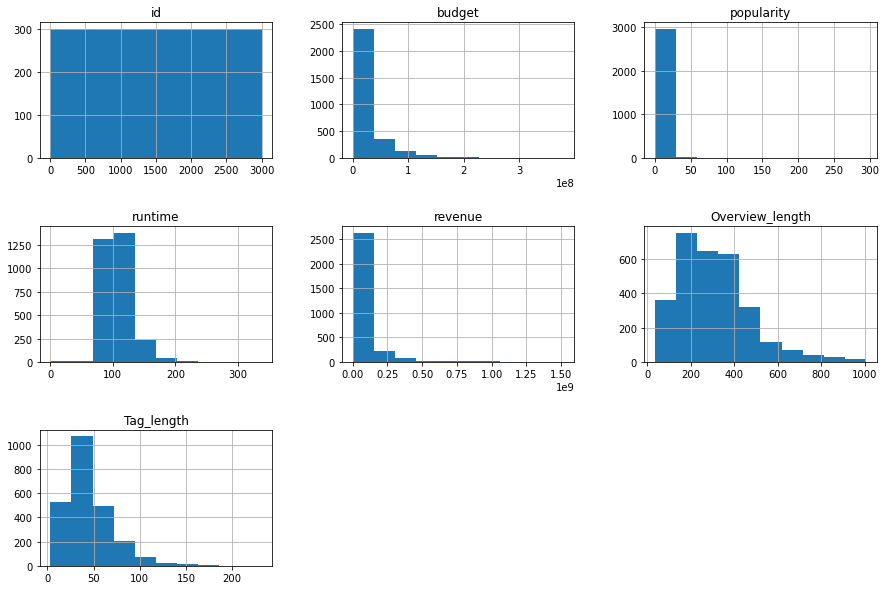

In [32]:
boxoffice.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

It looks like I may have a few outliers with revenue, budget, and potentially popularity as well.  

In [33]:
boxoffice.loc[boxoffice.popularity > 50]    #looking at films whose popularity is significantly above the norm

,id,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,revenue,Overview_length,Tag_length
2,3,NA,3300000,[Drama],tt2582802,en,Whiplash,Under the direct...,64.30,"[Bold Films, Blu...",[United States o...,10/10/14,105.00,[English],The road to grea...,Whiplash,"[jazz, obsession...","[Miles Teller, J...","[Terri Taylor, R...",13092000,130.00,47.00
518,519,Wonder Woman Col...,149000000,"[Action, Adventu...",tt0451279,en,Wonder Woman,An Amazon prince...,294.34,[Dune Entertainm...,[United States o...,5/30/17,141.00,"[Deutsch, English]",Power. Grace. Wi...,Wonder Woman,"[dc comics, hero...",None,None,820580447,94.00,29.00
684,685,NA,160000000,"[Family, Fantasy...",tt2771200,en,Beauty and the B...,A live-action ad...,287.25,[Walt Disney Pic...,"[United Kingdom,...",3/16/17,129.00,[English],Be our guest.,Beauty and the B...,"[france, magic, ...","[Emma Watson, Da...","[Bill Condon, St...",1262886337,165.00,13.00
1126,1127,The Avengers Col...,220000000,[Science Fiction...,tt0848228,en,The Avengers,When an unexpect...,89.89,[Paramount Pictu...,[United States o...,4/25/12,143.00,[English],Some assembly re...,The Avengers,"[new york, shiel...",[Robert Downey J...,"[Alan Silvestri,...",1519557910,297.00,23.00
1309,1310,NA,61000000,"[Mystery, Thrill...",tt2267998,en,Gone Girl,With his wife's ...,154.80,[Twentieth Centu...,[United States o...,10/1/14,145.00,[English],You don't know w...,Gone Girl,"[based on novel,...","[Ben Affleck, Ro...","[David Fincher, ...",369330363,169.00,43.00
1673,1674,The Dark Knight ...,185000000,"[Drama, Action, ...",tt0468569,en,The Dark Knight,Batman raises th...,123.17,"[DC Comics, Lege...","[United Kingdom,...",7/16/08,152.00,"[English, 普通话]",Why So Serious?,The Dark Knight,"[dc comics, crim...","[Christian Bale,...","[Lucinda Syson, ...",1004558444,396.00,15.00
1695,1696,NA,34000000,"[Action, Crime]",tt3890160,en,Baby Driver,After being coer...,228.03,[Big Talk Produc...,"[United Kingdom,...",6/28/17,113.00,[English],All you need is ...,Baby Driver,"[robbery, atlant...","[Ansel Elgort, L...","[Edgar Wright, E...",224511319,126.00,33.00
1715,1716,Planet of the Ap...,152000000,"[Drama, Science ...",tt3450958,en,War for the Plan...,Caesar and his a...,146.16,[Chernin Enterta...,"[Canada, United ...",7/11/17,140.00,[English],For freedom. For...,War for the Plan...,"[based on novel,...","[Andy Serkis, Wo...","[William Hoy, Mi...",369907963,441.00,40.00
1783,1784,The Wolverine Co...,97000000,"[Action, Drama, ...",tt3315342,en,Logan,In the near futu...,54.58,[Twentieth Centu...,[United States o...,2/28/17,137.00,"[English, Español]",His time has come,Logan,"[cyborg, experim...",None,None,616801808,225.00,17.00
2016,2017,NA,25000000,"[Drama, Crime]",tt0111161,en,The Shawshank Re...,Framed in the 19...,51.65,[Castle Rock Ent...,[United States o...,9/23/94,142.00,[English],Fear can hold yo...,The Shawshank Re...,"[prison, corrupt...","[Tim Robbins, Mo...","[Frank Darabont,...",28341469,388.00,50.00


After looking at TMDB's API documentation it seems that popularity is a metric that's derived from a lot of complicated user interactions (movie added to watchlist, voted for, viewed on their website, searched for, etc) to arrive and a popularity score. Given this, while there are several films clustered abot a score of 200 there's no reason to drop those films as of now.  Particularly given the idiosycrasies of cultural content going 'viral' online this isn't too concerning right now. Moving forward it's best to keep in mind that the popularity metric is derived from TMDB's web analytics and may need to be treated with caution. 

In [34]:
boxoffice[boxoffice.budget > 2e8]   #examining films whose budget exceeded 2 million USD

,id,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,revenue,Overview_length,Tag_length
666,667,The Hobbit Colle...,250000000,"[Adventure, Fant...",tt1170358,en,The Hobbit: The ...,"The Dwarves, Bil...",20.64,"[WingNut Films, ...","[New Zealand, Un...",12/11/13,161.00,[English],Beyond darkness....,The Hobbit: The ...,"[elves, dwarves,...","[Martin Freeman,...",[Victoria Burrow...,958400000,191.00,72.00
906,907,The Dark Knight ...,250000000,"[Action, Crime, ...",tt1345836,en,The Dark Knight ...,Following the de...,20.58,[Legendary Pictu...,[United States o...,7/16/12,165.00,[English],The Legend Ends,The Dark Knight ...,"[dc comics, crim...",None,None,1084939099,428.00,15.00
961,962,Harry Potter Col...,250000000,"[Adventure, Fant...",tt0417741,en,Harry Potter and...,As Harry begins ...,19.08,"[Warner Bros., H...","[United Kingdom,...",7/7/09,153.00,[English],Dark Secrets Rev...,Harry Potter and...,"[witch, magic, b...",[Daniel Radcliff...,[Bruno Delbonnel...,933959197,174.00,21.00
1126,1127,The Avengers Col...,220000000,[Science Fiction...,tt0848228,en,The Avengers,When an unexpect...,89.89,[Paramount Pictu...,[United States o...,4/25/12,143.00,[English],Some assembly re...,The Avengers,"[new york, shiel...",[Robert Downey J...,"[Alan Silvestri,...",1519557910,297.00,23.00
1249,1250,The Chronicles o...,225000000,"[Adventure, Fami...",tt0499448,en,The Chronicles o...,One year after t...,12.49,"[Walt Disney, Wa...","[Czech Republic,...",5/15/08,150.00,[English],Hope has a new f...,The Chronicles o...,"[based on novel,...","[Ben Barnes, Wil...","[Liz Mullane, Ga...",419651413,437.00,20.00
1270,1271,NA,260000000,"[Action, Adventu...",tt0401729,en,John Carter,John Carter is a...,14.67,[Walt Disney Pic...,[United States o...,3/7/12,132.00,[English],Lost in our worl...,John Carter,"[based on novel,...","[Taylor Kitsch, ...","[Andrew Stanton,...",284139100,342.00,36.00
1425,1426,Superman Collection,270000000,"[Adventure, Fant...",tt0348150,en,Superman Returns,Superman returns...,13.28,"[DC Comics, Lege...",[United States o...,6/28/06,154.00,"[English, França...",NaN,Superman Returns,[saving the worl...,"[Brandon Routh, ...",[Roger Mussenden...,391081192,308.00,nan
1630,1631,Transformers Col...,260000000,"[Action, Science...",tt3371366,en,Transformers: Th...,Autobots and Dec...,39.19,[Paramount Pictu...,[United States o...,6/21/17,149.00,[English],For one world to...,Transformers: Th...,"[knight, transfo...","[Mark Wahlberg, ...","[Akiva Goldsman,...",604942143,206.00,42.00
1880,1881,X-Men Collection,210000000,"[Adventure, Acti...",tt0376994,en,X-Men: The Last ...,When a cure is f...,0.87,[Ingenious Film ...,"[Canada, United ...",5/24/06,104.00,[English],Take a Stand,X-Men: The Last ...,"[mutant, marvel ...","[Hugh Jackman, H...","[Mark Goldblatt,...",459359555,169.00,12.00
2035,2036,NA,207000000,"[Adventure, Dram...",tt0360717,en,King Kong,In 1933 New York...,19.76,"[WingNut Films, ...","[New Zealand, Un...",12/14/05,187.00,[English],The eighth wonde...,King Kong,"[film business, ...","[Naomi Watts, Ja...",[James Newton Ho...,550000000,216.00,31.00


Same as for the popularity, budget had a long tailed distribution.  I could drop films above 200 million in budget, however that would ultimately be arbitrary and after some quick google searches it's apparent that the budget information here is accurate. 

In [35]:
boxoffice[boxoffice.revenue > 1e9]   #examining films whose revenue exceeded 1 billion USD

,id,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,revenue,Overview_length,Tag_length
684,685,NA,160000000,"[Family, Fantasy...",tt2771200,en,Beauty and the B...,A live-action ad...,287.25,[Walt Disney Pic...,"[United Kingdom,...",3/16/17,129.00,[English],Be our guest.,Beauty and the B...,"[france, magic, ...","[Emma Watson, Da...","[Bill Condon, St...",1262886337,165.00,13.00
734,735,NA,150000000,"[Animation, Adve...",tt2948356,en,Zootopia,Determined to pr...,26.02,[Walt Disney Pic...,[United States o...,2/11/16,108.00,[English],Welcome to the u...,Zootopia,"[fox, prejudice,...",[Ginnifer Goodwi...,"[Byron Howard, C...",1023784195,220.00,28.00
881,882,Alice in Wonderl...,200000000,"[Family, Fantasy...",tt1014759,en,Alice in Wonderland,"Alice, an unpret...",17.29,[Walt Disney Pic...,[United States o...,3/3/10,108.00,[English],You're invited t...,Alice in Wonderland,"[based on novel,...","[Mia Wasikowska,...","[Dariusz Wolski,...",1025491110,628.00,40.00
906,907,The Dark Knight ...,250000000,"[Action, Crime, ...",tt1345836,en,The Dark Knight ...,Following the de...,20.58,[Legendary Pictu...,[United States o...,7/16/12,165.00,[English],The Legend Ends,The Dark Knight ...,"[dc comics, crim...",None,None,1084939099,428.00,15.00
1126,1127,The Avengers Col...,220000000,[Science Fiction...,tt0848228,en,The Avengers,When an unexpect...,89.89,[Paramount Pictu...,[United States o...,4/25/12,143.00,[English],Some assembly re...,The Avengers,"[new york, shiel...",[Robert Downey J...,"[Alan Silvestri,...",1519557910,297.00,23.00
1673,1674,The Dark Knight ...,185000000,"[Drama, Action, ...",tt0468569,en,The Dark Knight,Batman raises th...,123.17,"[DC Comics, Lege...","[United Kingdom,...",7/16/08,152.00,"[English, 普通话]",Why So Serious?,The Dark Knight,"[dc comics, crim...","[Christian Bale,...","[Lucinda Syson, ...",1004558444,396.00,15.00
1761,1762,The Fast and the...,190000000,[Action],tt2820852,en,Furious 7,Deckard Shaw see...,27.28,[Universal Pictu...,"[Japan, United S...",4/1/15,137.00,[English],Vengeance Hits Home,Furious 7,"[car race, speed...","[Vin Diesel, Pau...","[Vin Diesel, Nea...",1506249360,91.00,19.00
2135,2136,Pirates of the C...,380000000,"[Adventure, Acti...",tt1298650,en,Pirates of the C...,Captain Jack Spa...,27.89,[Walt Disney Pic...,[United States o...,5/14/11,136.00,"[English, Español]",Live Forever Or ...,Pirates of the C...,"[sea, captain, m...","[Johnny Depp, Pe...","[Dariusz Wolski,...",1045713802,411.00,27.00
2322,2323,Transformers Col...,195000000,"[Action, Science...",tt1399103,en,Transformers: Da...,Sam Witwicky tak...,4.50,[Paramount Pictu...,[United States o...,6/28/11,154.00,[English],The invasion we ...,Transformers: Da...,"[moon, spacecraf...","[Shia LaBeouf, J...","[Denise Chamian,...",1123746996,313.00,58.00
2532,2533,The Hobbit Colle...,250000000,"[Adventure, Fant...",tt0903624,en,The Hobbit: An U...,"Bilbo Baggins, a...",23.25,"[WingNut Films, ...","[New Zealand, Un...",11/26/12,169.00,[English],From the smalles...,The Hobbit: An U...,"[riddle, elves, ...","[Ian McKellen, M...","[Peter Jackson, ...",1021103568,181.00,55.00


Again, it's good to check for significant outliers or errors.  The outliers for revenue don't seem to be incorrect, and while I could drop movies that grossed over a billion dollars in revenue that would be fairly arbitrary.  

It is notable that the outliers for revenue have little to no overlap with the films who's popularity was exceptionally high - this is something I definitely want to explore in a later notebook. 

### Final check on the data and saving the cleaned dataframe

In [38]:
boxoffice['collectionbool'] = Collection_bool

boxoffice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  3000 non-null   object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   imdb_id                3000 non-null   object 
 5   original_language      3000 non-null   object 
 6   original_title         3000 non-null   object 
 7   overview               2992 non-null   object 
 8   popularity             3000 non-null   float64
 9   production_companies   2844 non-null   object 
 10  production_countries   2945 non-null   object 
 11  release_date           3000 non-null   object 
 12  runtime                2998 non-null   float64
 13  spoken_languages       2980 non-null   object 
 14  tagline                2403 non-null   object 
 15  titl

There are still some missing values in the dataset that I need to be aware of, but I'll leave things as is for now and save this as a cleaned .csv

In [40]:
boxoffice.to_csv(r'C:\Users\deann\Documents\Data\Box Office Prediction Data\boxoffice_data.csv', index=False)

### Summary

This was my notebook containing the data wrangling work to create a predictive model for a film's boxoffice revenue.  

In this notebook I imported the dataset from TMDB (via Kaggle), and examined it for missing values.  Immediately it was apparent that two columns 'belongs_to_collection' and 'homepage' had significant missing values.  It was also readily apparent that several of the columns were lists of dictionaries that would be complex to work with, and that I had a few columns that weren't needed. 

Ultimately I chose to drop the columns for 'id', 'homepage', 'poster_path', and 'status'.  Both 'homepage' and 'poster_path' were links to external websites, while 'id' was a duplicate of the index and 'status' was the same value for all movies. 

I also added three new columns: 'collectionbool' as a boolean mask indicating if a movie is part of a larger collection, 'Overview_length' and 'Tag_length' I engineered to provide a numeric value for both the film's plot overview and tagline since both are used in marketing efforts and could contribute to a films revenue.

I imported the ***ast*** library in order to use the literal_eval method on the values in 'belongs_to_colleection'.  This column's values were lists of dictionaries, formatted as strings so I was unable to extract the dictionary values normally. Using this I extracted only the name of the film collection and replace the original values for the column with that.  

Since that worked well, I then was able to write a function that allowed me to extract the names of the production companies, countries, spoken languages, cast, and crew. 


Finally I examined the distribution of numerical values to identify any concerning outliers in the data.  While I do have some extreme values in revenue and budget, they are all accurate so I chose to leave them in.  The popularity metric has some rather large values as well, and is derived from user behavior on TMDB's website.  I chose to keep the outliers for now, however that column may ultimately be dropped if it has little correlation with the actual revenue. 

If you'd like to read more, my next notebook will examine the relationships between numeric variables and start to look at the impact of different categorical variables as well. 
